In [131]:
## Library
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import col
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt

# For Data Frame
from pyspark.sql.functions import col, to_date, date_format, lit,expr
import random

#For Figures
import matplotlib.pyplot as plt  #Plot
import pyspark.sql.functions as F  #SQL
from pyspark.sql.window import Window
import numpy as np
import pandas as pd
import textwrap
from pandas.plotting import register_matplotlib_converters
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as sum_
from pyspark.sql.functions import col

import matplotlib.dates as mdates
from pyspark.sql.functions import to_date, date_trunc, col   # Date
import seaborn as sns

In [132]:
# Make Spark Session, Data Frame, Read Data
spark = SparkSession.builder \
.master("local") \
.appName("abappy") \
.getOrCreate()

df = spark.read.csv('/mnt/group-14-pvc/processed_data', header = True, inferSchema = True)

#df.show(vertical=False)
df.printSchema()
#df.show(5)
print("total data:")
df.count()

root
 |-- supermarket: string (nullable = true)
 |-- price: double (nullable = true)
 |-- price_unit: double (nullable = true)
 |-- measure_unit: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- product_category: string (nullable = true)
 |-- own_brand: boolean (nullable = true)
 |-- city: string (nullable = true)

total data:


2104337

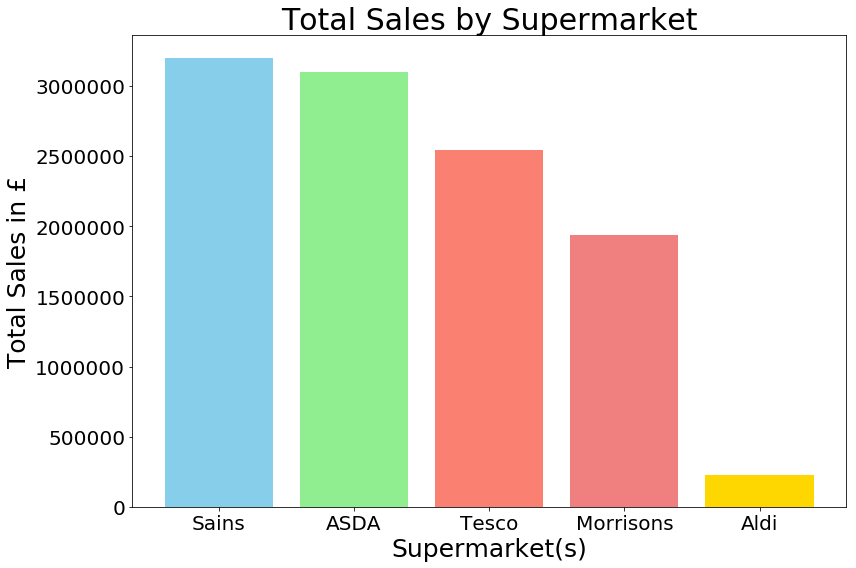

In [14]:
## FIG 1. Total Sales by Supermarket (sorted) 

# Group by "supermarket" and calculate total sales
sales_by_supermarket = df.groupby("supermarket").agg(F.sum("price").alias("total_sales"))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
sales_pd = sales_by_supermarket.toPandas()

# Sort the DataFrame by total sales in descending order
sales_pd = sales_pd.sort_values(by="total_sales", ascending=False)

# Define colors for the bars, ensure there are enough colors for the number of supermarkets
# If there are more supermarkets than colors, consider using a colormap or cycling through colors
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold', 'lightblue'] * (len(sales_pd) // 6 + 1)

# Plot the bar graph
plt.figure(figsize=(12,8))
plt.bar(sales_pd["supermarket"], sales_pd["total_sales"], color=colors[:len(sales_pd)], align='center')
plt.xlabel("Supermarket(s)", fontsize=25)
plt.ylabel("Total Sales in £", fontsize=25)
plt.title("Total Sales by Supermarket", fontsize=30)
plt.xticks(rotation=0, ha='center', fontsize=20)  # Adjust rotation if labels are overlapping
plt.yticks(fontsize=20)
plt.tight_layout()

plt.show()


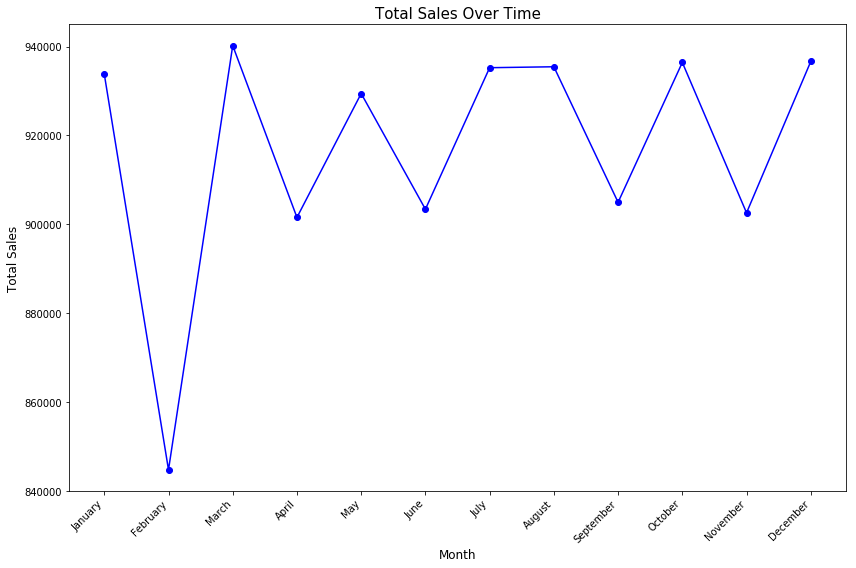

In [8]:
## FIG 2. Total Sales Over Time (Month)

from pyspark.sql.functions import to_date, date_trunc, col

# Assuming your date strings are in a format like 'yyyy-MM-dd'
# Convert the string to date format and then truncate to the first day of each month
df = df.withColumn("date", to_date(df.date, "yyyy-MM-dd"))
df = df.withColumn("month", date_trunc("month", df.date))

# Group by "month" instead of "date" and calculate total sales for all supermarkets
sales_by_month = df.groupby("month").agg(F.sum("price").alias("total_sales"))

# Sort the results by month
sales_by_month = sales_by_month.orderBy("month")

# Convert PySpark DataFrame to Pandas DataFrame for plotting
sales_pd = sales_by_month.toPandas()

# Since "month" is a datetime column, convert it to just month for plotting
sales_pd['month'] = sales_pd['month'].dt.strftime('%B')  #%Y-%m,%B

# Plot the line graph
plt.figure(figsize=(12, 8))
plt.plot(sales_pd["month"], sales_pd["total_sales"], color='blue', marker='o', linestyle='-')
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.title("Total Sales Over Time", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


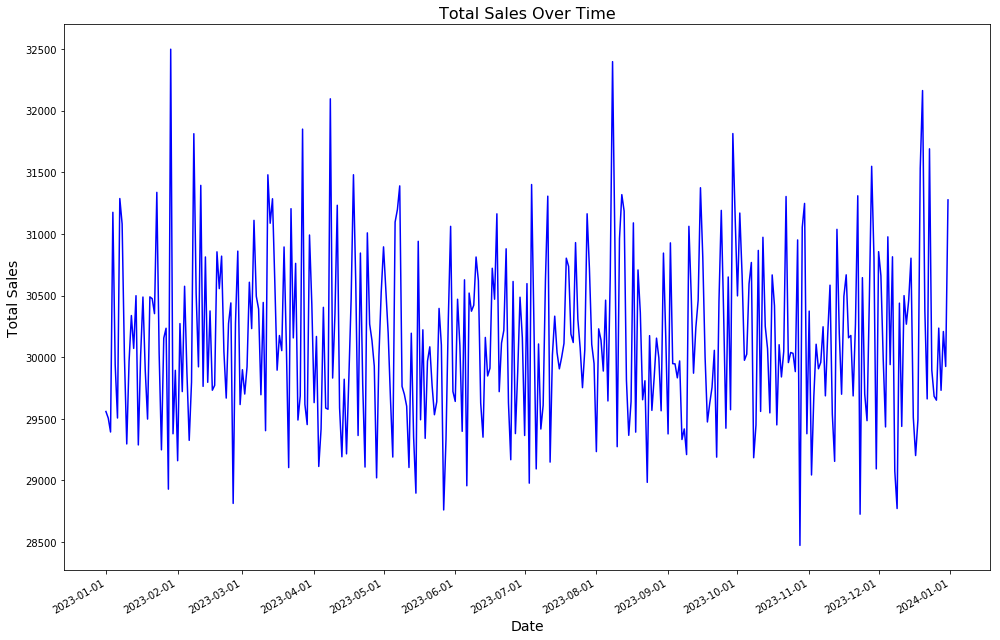

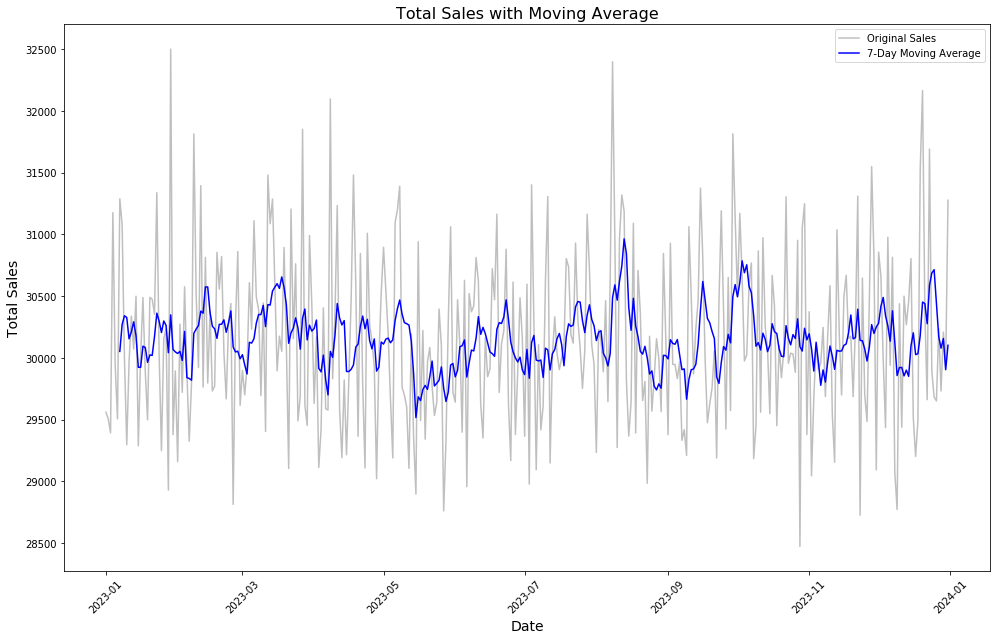

In [24]:
## FIG 2. Total Sales Over Time (Day + Smoothen)

# from pyspark.sql import SparkSession
# from pyspark.sql import functions as F
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd
# from pandas.plotting import register_matplotlib_converters

# Register matplotlib converters
register_matplotlib_converters()

# Initialize SparkSession
spark = SparkSession.builder.appName("Sales Analysis").getOrCreate()

# Assuming 'df' is your PySpark DataFrame with at least 'date' and 'price' columns

# Aggregate Sales by Date
sales_by_date = df.groupBy(F.to_date("date").alias("date")).agg(F.sum("price").alias("total_sales"))

# Convert to Pandas DataFrame for plotting
sales_by_date_pd = sales_by_date.toPandas()
sales_by_date_pd['date'] = pd.to_datetime(sales_by_date_pd['date'])
sales_by_date_pd.sort_values('date', inplace=True)

# Plot Total Sales Over Time
plt.figure(figsize=(14, 9))
plt.plot(sales_by_date_pd['date'], sales_by_date_pd['total_sales'], linestyle='-', color='blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Adjust locator based on your data
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
plt.title('Total Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tight_layout()
plt.show()

# Plotting the Moving Average
plt.figure(figsize=(14, 9))
sales_by_date_pd['moving_avg'] = sales_by_date_pd['total_sales'].rolling(window=7).mean()  # 7-day moving average
plt.plot(sales_by_date_pd['date'], sales_by_date_pd['total_sales'], alpha=0.5, color='gray', label='Original Sales')  # Original sales
plt.plot(sales_by_date_pd['date'], sales_by_date_pd['moving_avg'], color='blue', label='7-Day Moving Average')  # Moving average
plt.title('Total Sales with Moving Average', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



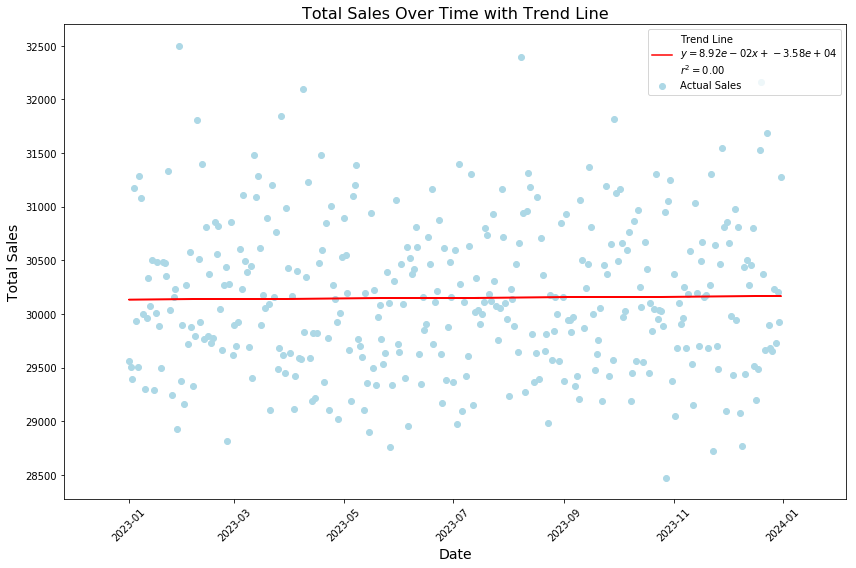

In [27]:
## FIG 2. Total Sales Over Time (TREND)

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from scipy.stats import linregress
from pyspark.sql.functions import sum as Fsum, to_date

# Aggregate sales by date
sales_by_date = df.groupBy(to_date("date").alias("date")).agg(Fsum("price").alias("total_sales"))

# Convert the aggregated Spark DataFrame to a Pandas DataFrame
sales_by_date_pd = sales_by_date.toPandas()
# Convert dates to ordinal numbers for linear regression
sales_by_date_pd['date_ordinal'] = pd.to_datetime(sales_by_date_pd['date']).apply(lambda date: date.toordinal())

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(sales_by_date_pd['date_ordinal'], sales_by_date_pd['total_sales'])

# Calculate the line of best fit
line = slope * sales_by_date_pd['date_ordinal'] + intercept

# Plotting the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sales_by_date_pd['date'], sales_by_date_pd['total_sales'], color='lightblue', label='Actual Sales')

# Plotting the trend line
plt.plot(sales_by_date_pd['date'], line, color='red', label=f'Trend Line\n$y={slope:.2e}x + {intercept:.2e}$\n$r^2={r_value**2:.2f}$')

plt.title('Total Sales Over Time with Trend Line', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


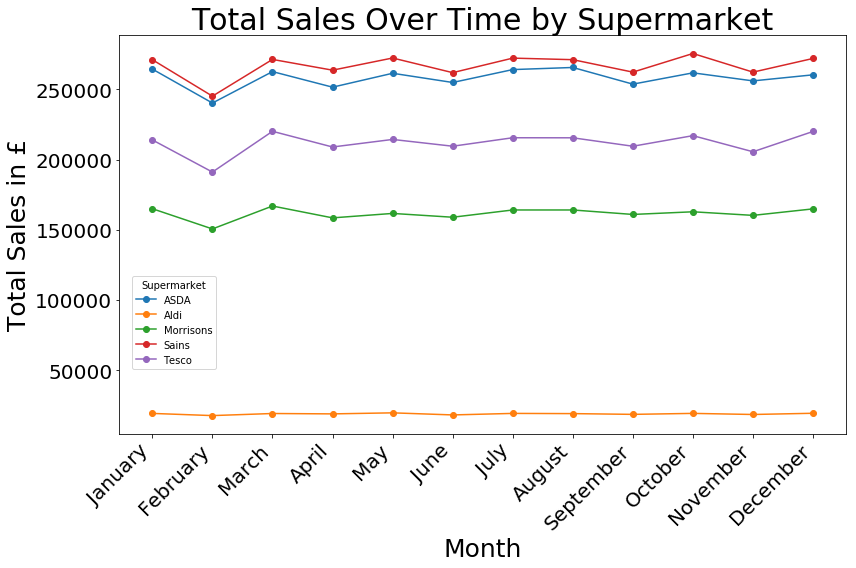

In [15]:
## Fig 3. Total Sales Over Time by Supermarket

#from pyspark.sql.functions import to_date, date_trunc, col

# Convert the string to date format and then truncate to the first day of each month
df = df.withColumn("date", to_date(df.date, "yyyy-MM-dd"))
df = df.withColumn("month", date_trunc("month", df.date))

# Group by "supermarket" and "month", then calculate total sales
sales_by_supermarket_month = df.groupby("supermarket", "month").agg(F.sum("price").alias("total_sales"))

# Sort the results by month within each supermarket
sales_by_supermarket_month = sales_by_supermarket_month.orderBy("supermarket", "month")

# Convert PySpark DataFrame to Pandas DataFrame for plotting
sales_pd = sales_by_supermarket_month.toPandas()

# Convert "month" column to month names for plotting, consider including year if necessary
sales_pd['month_name'] = sales_pd['month'].dt.strftime('%B')

# Plotting
plt.figure(figsize=(12, 8))

# Get unique list of supermarkets for iteration
supermarkets = sales_pd['supermarket'].unique()

for supermarket in supermarkets:
    # Filter data for each supermarket
    df_filtered = sales_pd[sales_pd['supermarket'] == supermarket]
    # Plot each supermarket's total sales over time
    plt.plot(df_filtered["month_name"], df_filtered["total_sales"], marker='o', linestyle='-', label=supermarket)

plt.xlabel("Month", fontsize=25)
plt.ylabel("Total Sales in £", fontsize=25)
plt.title("Total Sales Over Time by Supermarket", fontsize=30)
plt.xticks(rotation=45, ha='right', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(title="Supermarket", loc='lower left', bbox_to_anchor=(0.01, 0.15))
plt.tight_layout()

plt.show()


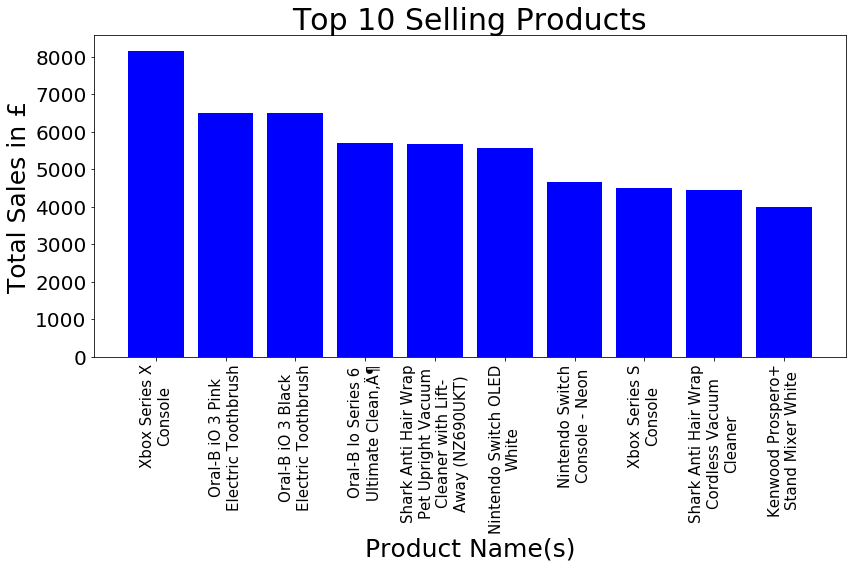

In [19]:
## Fig 4.1 Top 10 Selling Products of all supermarkets 

# import matplotlib.pyplot as plt
# import pandas as pd
# import textwrap


# Calculate total sales per product across all supermarkets
total_sales_per_product = df.groupBy("product_name") \
                             .agg(sum_("price").alias("total_sales")) \
                             .orderBy(col("total_sales").desc())

# Get top 10 selling products
top_10_products = total_sales_per_product.limit(10)

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
top_10_products_pd = top_10_products.toPandas()

# Function to split long names into multiple lines
def split_name(name, width):
    """Splits a name into multiple lines if longer than width."""
    return '\n'.join(textwrap.wrap(name, width))

# Apply the function to split product names correctly
top_10_products_pd['product_name'] = top_10_products_pd['product_name'].apply(lambda x: split_name(x, width=20))

# Plot the bar graph for the top 10 selling products
plt.figure(figsize=(12,8))
colors = ['blue' if i % 2 == 0 else 'blue' for i in range(len(top_10_products_pd))]
# colors = ['skyblue' if i % 2 == 0 else 'lightgreen' for i in range(len(top_10_products_pd))]

plt.bar(top_10_products_pd["product_name"], top_10_products_pd["total_sales"], color=colors, align='center')
plt.xlabel("Product Name(s)", fontsize=25)
plt.ylabel("Total Sales in £", fontsize=25)
plt.title("Top 10 Selling Products", fontsize=30)

# Ensure matplotlib uses the adjusted product names correctly
plt.xticks(ticks=range(len(top_10_products_pd["product_name"])), labels=top_10_products_pd["product_name"], rotation=90, ha='center', fontsize=15)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.show()

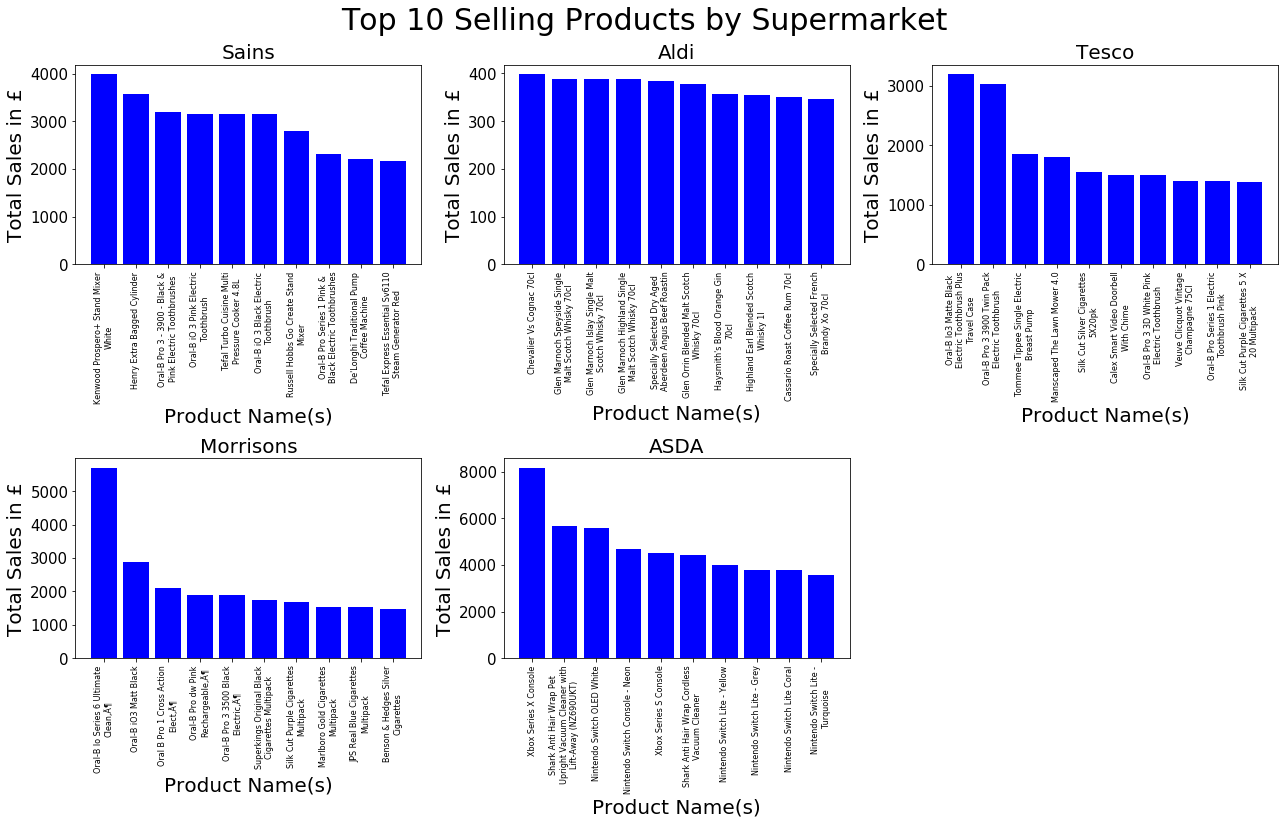

In [23]:
## Fig 4.2 Top 10 Selling Products for each Supermarket

# First, group by both 'supermarket' and 'product_name' to calculate total sales
total_sales = df.groupby("supermarket", "product_name").agg(F.sum("price").alias("total_sales"))

# Collect supermarkets (assuming there are exactly 5 unique supermarkets)
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Set up the matplotlib figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Top 10 Selling Products by Supermarket', fontsize=30)

# Remove the last subplot (if there are only 5 supermarkets) to make a grid of 2x3
fig.delaxes(axes[1,2])

# Function to split long names into multiple lines
def split_name(name, width=20):
    """Splits a name into multiple lines if longer than width."""
    return '\n'.join(textwrap.wrap(name, width))

for i, supermarket in enumerate(supermarkets):
    # For each supermarket, get the top 10 selling products
    top_10_products = total_sales.filter(total_sales.supermarket == supermarket) \
                                 .orderBy(F.col("total_sales").desc()).limit(10)
    
    # Convert to Pandas DataFrame for plotting
    top_10_products_pd = top_10_products.toPandas()
    
    # Apply the function to split product names
    top_10_products_pd['product_name'] = top_10_products_pd['product_name'].apply(lambda x: split_name(x, width=30))
    
    # Plotting on the respective subplot
    ax = axes.flatten()[i]
    colors = ['blue' if j % 2 == 0 else 'blue' for j in range(len(top_10_products_pd))]
    ax.bar(top_10_products_pd["product_name"], top_10_products_pd["total_sales"], color=colors, align='center')
    ax.set_title(supermarket, fontsize=20)
    ax.set_xlabel("Product Name(s)", fontsize=20)
    ax.set_ylabel("Total Sales in £", fontsize=20)
    ax.tick_params(axis='x', rotation=90,labelsize=8)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


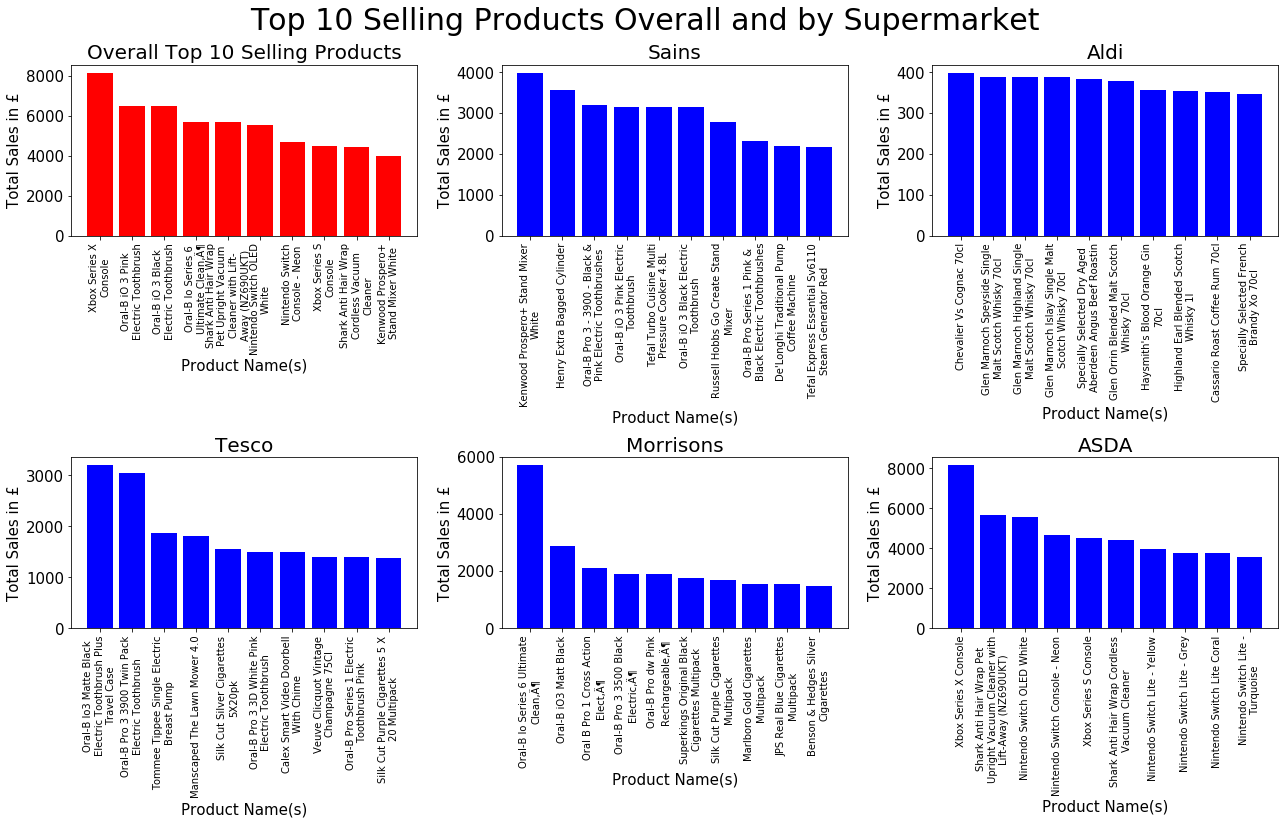

In [140]:
## top product names all 
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
from pyspark.sql.functions import sum as sum_, col

# Assuming 'df' is your Spark DataFrame containing the necessary data

# Calculate total sales per product across all supermarkets
total_sales_per_product = df.groupBy("product_name") \
                             .agg(sum_("price").alias("total_sales")) \
                             .orderBy(col("total_sales").desc())

# Get top 10 selling products globally
top_10_global_products = total_sales_per_product.limit(10)
top_10_global_products_pd = top_10_global_products.toPandas()
top_10_global_products_pd['product_name'] = top_10_global_products_pd['product_name'].apply(lambda x: split_name(x, width=20))

# Get top 10 selling products for each supermarket
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
supermarket_sales_data = {}

for supermarket in supermarkets:
    top_10_products = df.filter(df.supermarket == supermarket) \
                        .groupBy("product_name") \
                        .agg(sum_("price").alias("total_sales")) \
                        .orderBy(col("total_sales").desc()).limit(10)
    supermarket_sales_data[supermarket] = top_10_products.toPandas()
    supermarket_sales_data[supermarket]['product_name'] = supermarket_sales_data[supermarket]['product_name'].apply(lambda x: split_name(x, width=30))

# Set up the matplotlib figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # Adjust layout size accordingly
fig.suptitle('Top 10 Selling Products Overall and by Supermarket', fontsize=30)

# Plot the overall top 10 in the first subplot
ax_global = axes[0,0]
ax_global.bar(top_10_global_products_pd["product_name"], top_10_global_products_pd["total_sales"], color='red', align='center')  # Use red for differentiation
ax_global.set_title("Overall Top 10 Selling Products", fontsize=20)
ax_global.set_xlabel("Product Name(s)", fontsize=15)
ax_global.set_ylabel("Total Sales in £", fontsize=15)
ax_global.tick_params(axis='x', rotation=90, labelsize=10)
ax_global.tick_params(axis='y', labelsize=15)

# Plot top 10 for each supermarket in other subplots
for i, (supermarket, data) in enumerate(supermarket_sales_data.items(), start=1):
    row = (i // 3)
    col = (i % 3)
    ax = axes[row, col]
    ax.bar(data["product_name"], data["total_sales"], color='blue', align='center')
    ax.set_title(supermarket, fontsize=20)
    ax.set_xlabel("Product Name(s)", fontsize=15)
    ax.set_ylabel("Total Sales in £", fontsize=15)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


TypeError: 'int' object is not callable

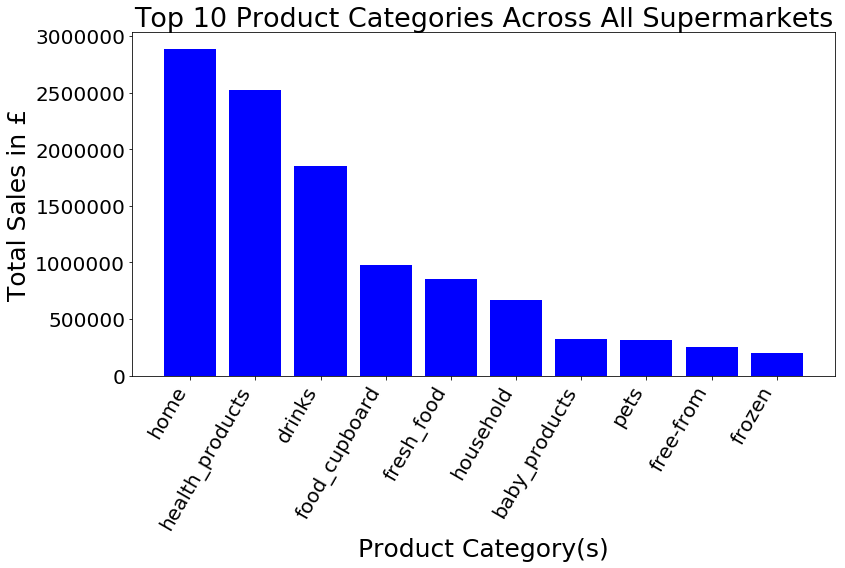

In [27]:
## Fig 5.1 Top 10 Selling Categories for all Supermarket

# Assuming 'df' is your PySpark DataFrame

# Group by 'product_category' to calculate total sales across all supermarkets
total_sales_by_category = df.groupby("product_category").agg(F.sum("price").alias("total_sales"))

# Get the top 10 product categories by total sales
top_10_categories = total_sales_by_category.orderBy(F.col("total_sales").desc()).limit(10)

# Convert to Pandas DataFrame for plotting
top_10_categories_pd = top_10_categories.toPandas()

# Plotting the top 10 product categories
plt.figure(figsize=(12, 8))
colors = ['blue' if i % 2 == 0 else 'blue' for i in range(len(top_10_categories_pd))]
plt.bar(top_10_categories_pd["product_category"], top_10_categories_pd["total_sales"], color=colors, align='center')
plt.title("Top 10 Product Categories Across All Supermarkets", fontsize=27)
plt.xlabel("Product Category(s)", fontsize=25)
plt.ylabel("Total Sales in £", fontsize=25)
plt.xticks(rotation=60, ha="right", fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

plt.show()


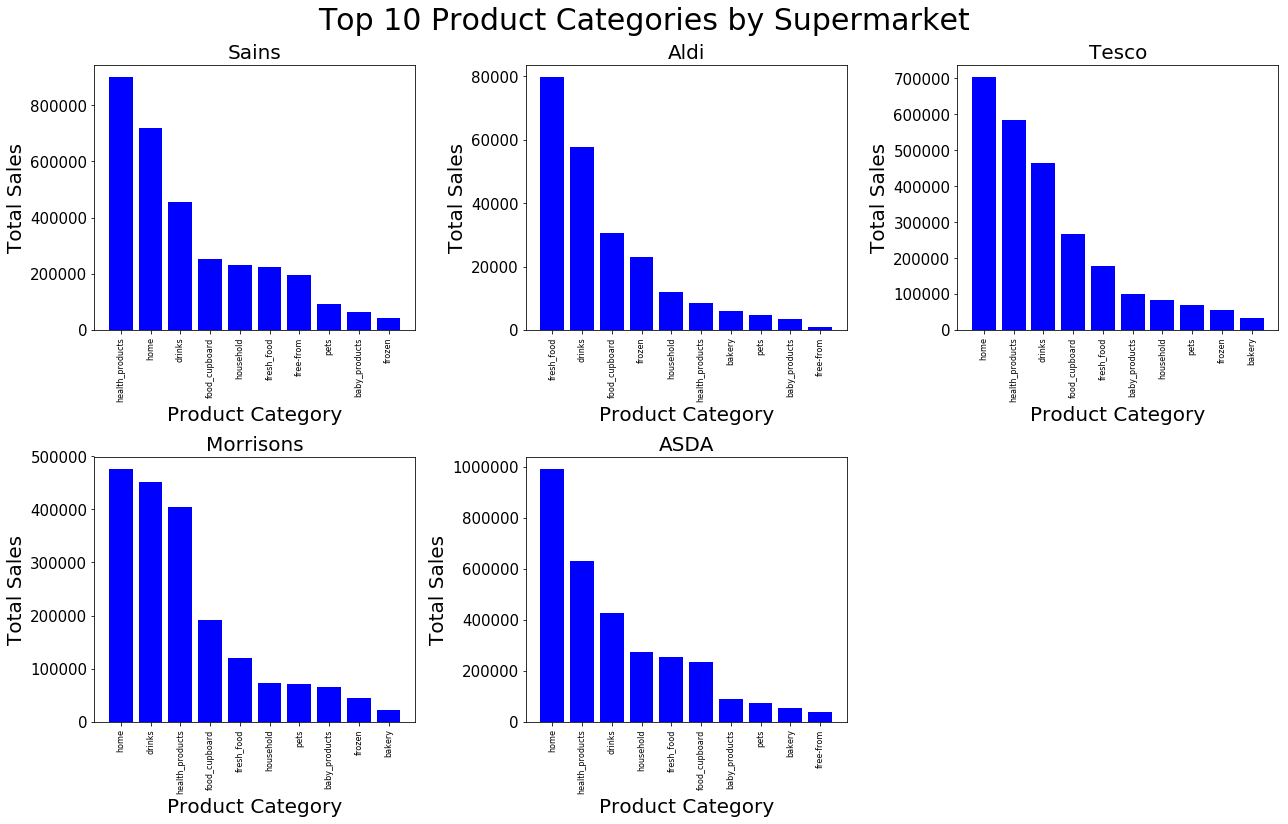

In [29]:
## Fig 5.2 Top 10 Product Categories for each supermarket
# Group by both 'supermarket' and 'product_category' to calculate total sales
total_sales_by_supermarket_category = df.groupby("supermarket", "product_category").agg(F.sum("price").alias("total_sales"))

# Collect supermarkets
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Determine subplot layout based on the number of supermarkets
n_supermarkets = len(supermarkets)
n_cols = 3  # You can adjust the number of columns
n_rows = (n_supermarkets + n_cols - 1) // n_cols  # Calculate rows needed for the subplots

# Set up the matplotlib figure and axes for the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 6 * n_rows))
fig.suptitle('Top 10 Product Categories by Supermarket', fontsize=30)

# Flatten axes array for easy access if it's 2D
axes = axes.flatten()

# Plotting loop
for i, supermarket in enumerate(supermarkets):
    # For each supermarket, get the top 10 product categories by total sales
    top_10_categories = total_sales_by_supermarket_category.filter(F.col("supermarket") == supermarket) \
                                                           .orderBy(F.col("total_sales").desc()).limit(10)
    
    # Convert to Pandas DataFrame for plotting
    top_10_categories_pd = top_10_categories.toPandas()
    
    # Plot on the respective subplot
    ax = axes[i]
    colors = ['blue' if j % 2 == 0 else 'blue' for j in range(len(top_10_categories_pd))]
    ax.bar(top_10_categories_pd["product_category"], top_10_categories_pd["total_sales"], color=colors, align='center')
    ax.set_title(supermarket, fontsize=20)
    ax.set_xlabel("Product Category", fontsize=20)
    ax.set_ylabel("Total Sales", fontsize=20)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.tick_params(axis='y', labelsize=15)

# If the number of supermarkets is not a multiple of n_cols, hide the extra subplots
for j in range(i + 1, n_cols * n_rows):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


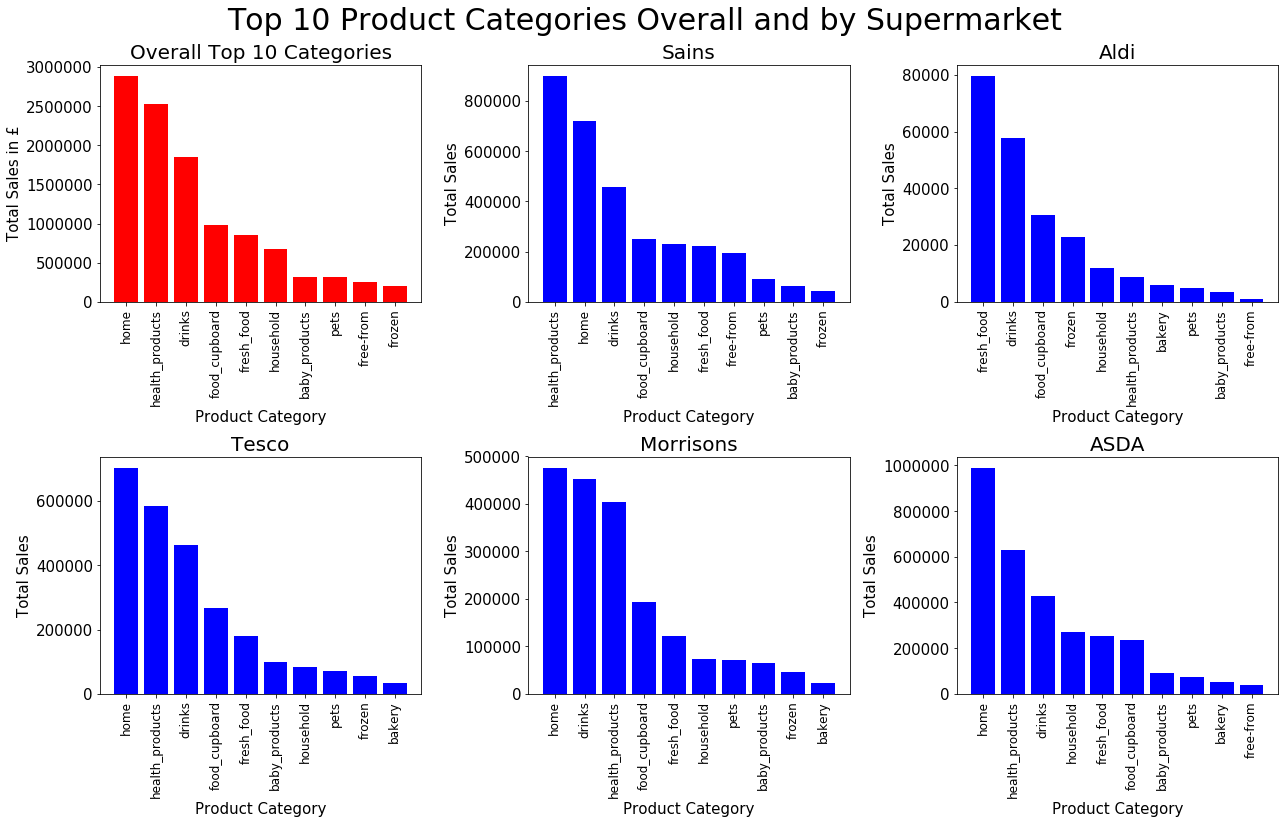

In [142]:
## top 10 types all 

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Assuming 'df' is your PySpark DataFrame

# Group by 'product_category' to calculate total sales across all supermarkets for the first plot
total_sales_by_category = df.groupby("product_category").agg(F.sum("price").alias("total_sales"))
top_10_categories = total_sales_by_category.orderBy(F.col("total_sales").desc()).limit(10)
top_10_categories_pd = top_10_categories.toPandas()

# Group by both 'supermarket' and 'product_category' to calculate total sales for the second set of plots
total_sales_by_supermarket_category = df.groupby("supermarket", "product_category").agg(F.sum("price").alias("total_sales"))
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Determine subplot layout
n_supermarkets = len(supermarkets)
n_cols = 3
n_rows = 2  # For 3x2 layout

# Set up the matplotlib figure and axes for the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 12))
fig.suptitle('Top 10 Product Categories Overall and by Supermarket', fontsize=30)

# Plot the overall top 10 in the first subplot
ax_global = axes[0, 0]
ax_global.bar(top_10_categories_pd["product_category"], top_10_categories_pd["total_sales"], color='red', align='center')
ax_global.set_title("Overall", fontsize=20)
ax_global.set_xlabel("Product Category", fontsize=15)
ax_global.set_ylabel("Total Sales in £", fontsize=15)
ax_global.tick_params(axis='x', rotation=90, labelsize=12)
ax_global.tick_params(axis='y', labelsize=15)

# Plot top 10 for each supermarket in other subplots
for i, supermarket in enumerate(supermarkets, start=1):
    ax = axes.flatten()[i]
    top_10_categories = total_sales_by_supermarket_category.filter(F.col("supermarket") == supermarket) \
                                                           .orderBy(F.col("total_sales").desc()).limit(10)
    top_10_categories_pd = top_10_categories.toPandas()
    
    ax.bar(top_10_categories_pd["product_category"], top_10_categories_pd["total_sales"], color='blue', align='center')
    ax.set_title(supermarket, fontsize=20)
    ax.set_xlabel("Product Category", fontsize=15)
    ax.set_ylabel("Total Sales", fontsize=15)
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=15)

# Hide unused subplots if there are any
for j in range(i + 1, n_cols * n_rows):
    axes.flatten()[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()


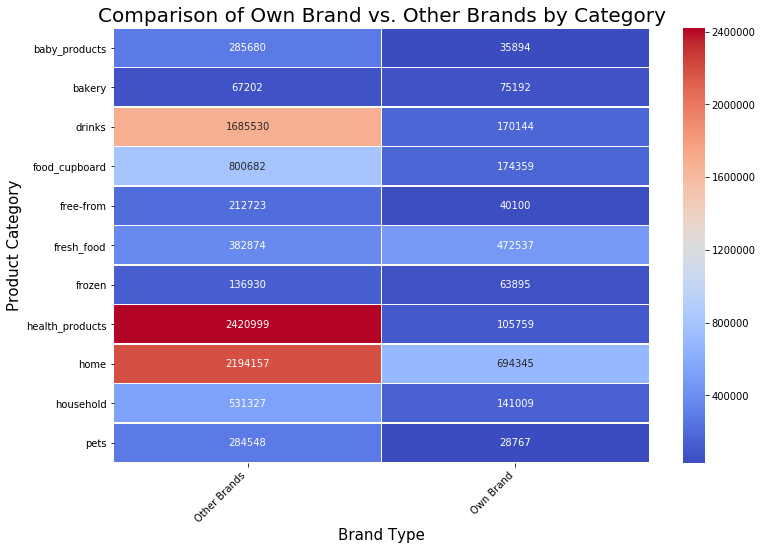

In [124]:
## HEATMAP OF OWN BRAND PERCENTAGE 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, when

# Start the Spark session
#spark = SparkSession.builder.appName("Brand Comparison by Category").getOrCreate()

# Assuming df is your DataFrame with the data already loaded
# Add a new column to differentiate between own brand and other brands
df2 = df.withColumn("brand_type", when(col("own_brand"), "Own Brand").otherwise("Other Brands"))

# Group by product category and brand type, then calculate total sales
brand_sales_by_category = df2.groupby("product_category", "brand_type").agg(_sum("price").alias("total_sales"))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
brand_sales_by_category_pd = brand_sales_by_category.toPandas()

# Pivot the DataFrame to get brand types as columns and categories as rows
pivot_table = brand_sales_by_category_pd.pivot(index='product_category', columns='brand_type', values='total_sales').fillna(0)

# Stop the Spark session
#spark.stop()



import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="coolwarm", linewidths=.5)

# Adding labels and title
plt.title('Comparison of Own Brand vs. Other Brands by Category', fontsize=20)
plt.xlabel('Brand Type', fontsize=15)
plt.ylabel('Product Category', fontsize=15)
plt.xticks(rotation=45, ha='right')

plt.show()

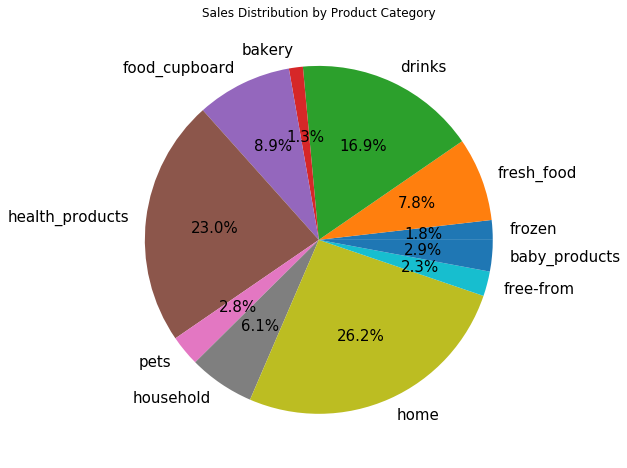

In [144]:
##Sales Distribution by Product Category (Pie Chart)

# Group by product category and sum sales
sales_by_category = df.groupBy("product_category").agg(F.sum("price").alias("total_sales"))

# Convert to Pandas DataFrame for plotting
sales_by_category_pd = sales_by_category.toPandas()

# Plot
plt.figure(figsize=(10, 8))
plt.pie(sales_by_category_pd['total_sales'], labels=sales_by_category_pd['product_category'], autopct='%3.1f%%',textprops={'fontsize': 15})
plt.title('Sales Distribution by Product Category')
plt.show()


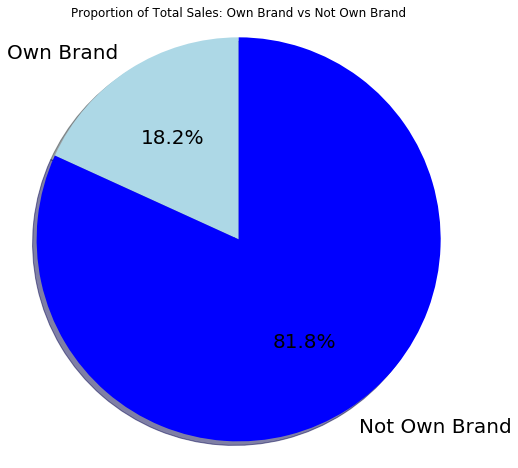

In [52]:
## Fig 7.1: Proportion of Total Sales: Own Brand vs Not Own Brand

# from pyspark.sql import functions as F
# import matplotlib.pyplot as plt


# Ensure 'own_brand' column only contains boolean values (True or False), excluding nulls if present
filtered_df = df.filter(df.own_brand.isNotNull())

# Aggregate sales by own_brand status
sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))

# Collect the aggregated data
sales_data = sales_by_own_brand.collect()

# Prepare data for the pie chart
labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
sizes = [row['total_sales'] for row in sales_data]
colors = ['lightblue', 'blue']  # Define two distinct colors

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 20})
plt.title('Proportion of Total Sales: Own Brand vs Not Own Brand')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

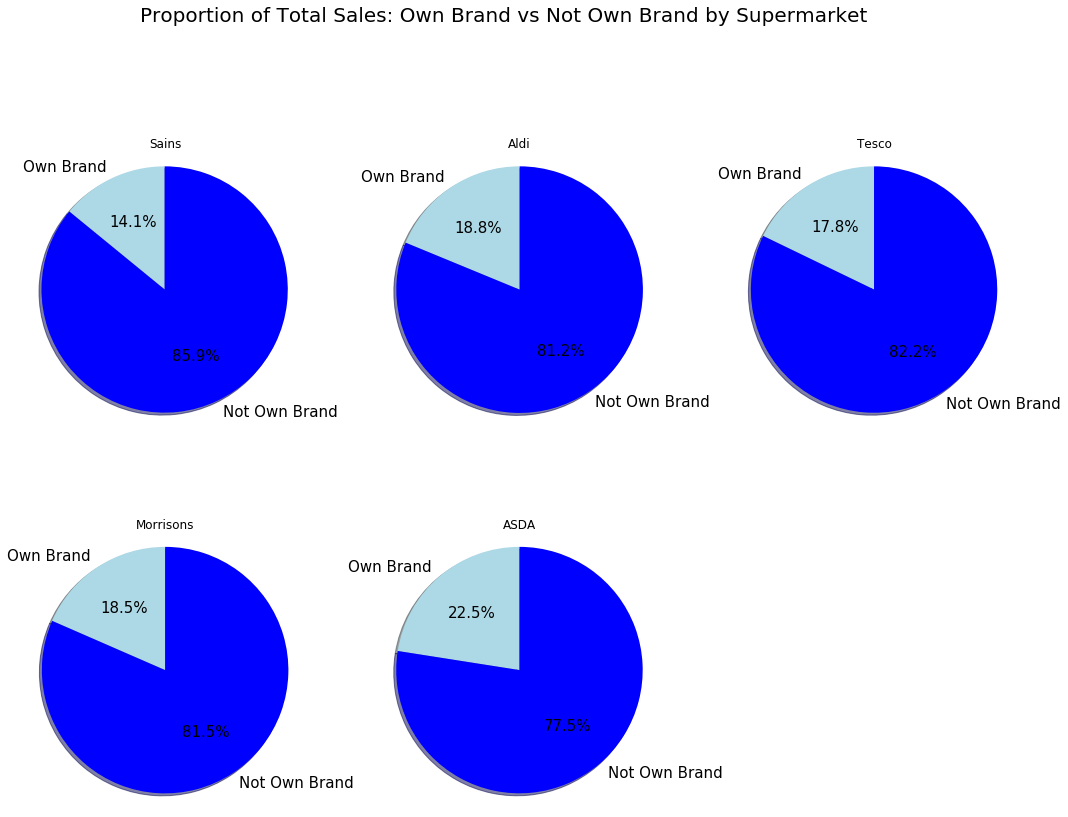

In [60]:
## Fig 7.2: Proportion of Total Sales: Own Brand vs Not Own Brand for each supermarket

# Get a list of supermarkets
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Set up the figure for multiple pie charts
n_supermarkets = len(supermarkets)
cols = 3  # Number of columns in the subplot grid
rows = n_supermarkets // cols + (n_supermarkets % cols > 0)  # Calculate required rows
fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust space between plots

# Colors for the pie charts
colors = ['lightblue', 'blue']

# Iterate through each supermarket and plot pie chart
for i, supermarket in enumerate(supermarkets):
    # Filter DataFrame for the current supermarket
    filtered_df = df.filter((df.supermarket == supermarket) & df.own_brand.isNotNull())

    # Aggregate sales by own_brand status
    sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
    
    # Collect the aggregated data
    sales_data = sales_by_own_brand.collect()

    # Prepare data for the pie chart
    labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
    sizes = [row['total_sales'] for row in sales_data]

    # Get current subplot
    ax = axs[i // cols, i % cols] if n_supermarkets > 1 else axs
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 15})
    ax.set_title(supermarket)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Hide any unused subplots
if n_supermarkets % cols > 0:
    for idx in range(i + 1, rows * cols):
        fig.delaxes(axs.flatten()[idx])

plt.suptitle('Proportion of Total Sales: Own Brand vs Not Own Brand by Supermarket', fontsize=20, y=1.05)
plt.show()


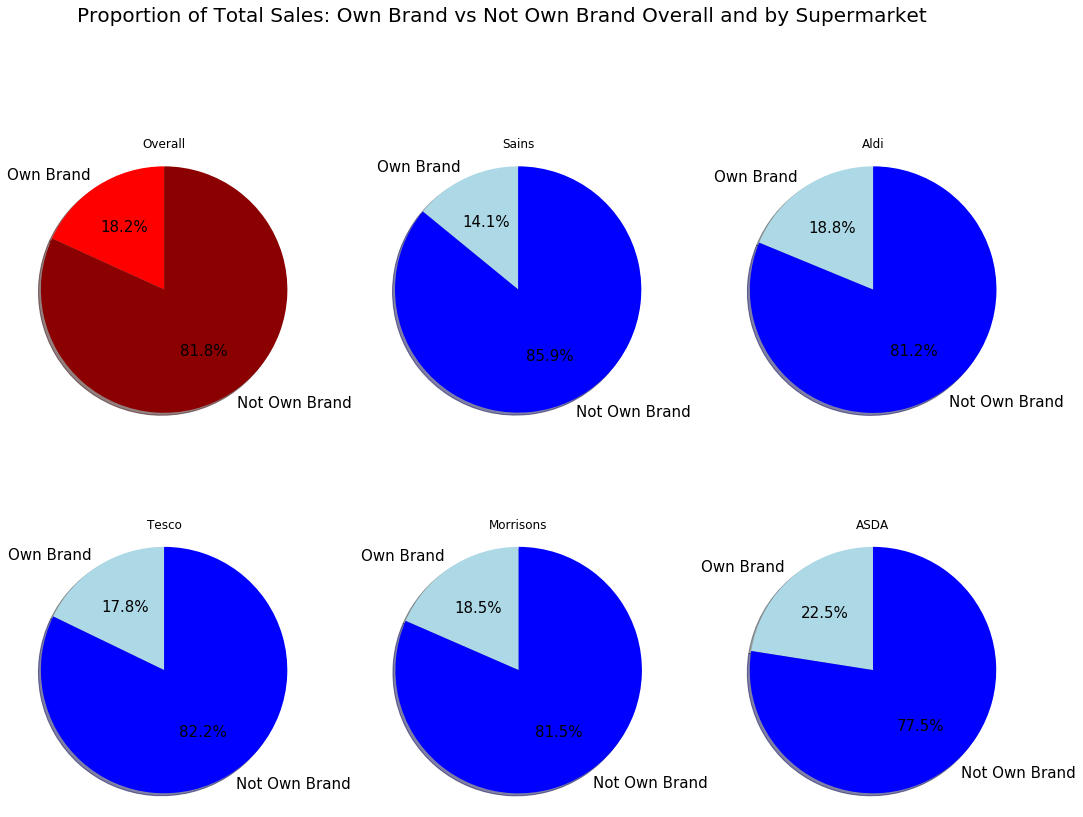

In [145]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Assuming 'df' is your PySpark DataFrame

# Get a list of supermarkets
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()

# Prepare the layout for the subplot
n_supermarkets = len(supermarkets) + 1  # +1 for the overall data
cols = 3
rows = n_supermarkets // cols + (n_supermarkets % cols > 0)  # Calculate required rows
fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)  # Adjust space between plots
fig.suptitle('Proportion of Total Sales: Own Brand vs Not Own Brand Overall and by Supermarket', fontsize=20, y=1.05)

# Colors for the pie charts
overall_colors = ['red', 'darkred']  # Distinct colors for the first chart
uniform_colors = ['lightblue', 'blue']  # Uniform colors for the supermarket-specific charts

# Plot the overall data first
filtered_df = df.filter(df.own_brand.isNotNull())
sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
sales_data = sales_by_own_brand.collect()
labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
sizes = [row['total_sales'] for row in sales_data]

ax = axs[0, 0]
ax.pie(sizes, labels=labels, colors=overall_colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 15})
ax.set_title('Overall')
ax.axis('equal')

# Iterate through each supermarket and plot pie chart
for i, supermarket in enumerate(supermarkets, start=1):
    # Filter DataFrame for the current supermarket
    filtered_df = df.filter((df.supermarket == supermarket) & df.own_brand.isNotNull())

    # Aggregate sales by own_brand status
    sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))
    
    # Collect the aggregated data
    sales_data = sales_by_own_brand.collect()

    # Prepare data for the pie chart
    labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
    sizes = [row['total_sales'] for row in sales_data]

    # Get current subplot
    ax = axs[i // cols, i % cols] if n_supermarkets > 1 else axs
    ax.pie(sizes, labels=labels, colors=uniform_colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 15})
    ax.set_title(supermarket)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Hide any unused subplots
for idx in range(i + 1, rows * cols):
    if idx < axs.size:
        axs.flatten()[idx].axis('off')

plt.show()


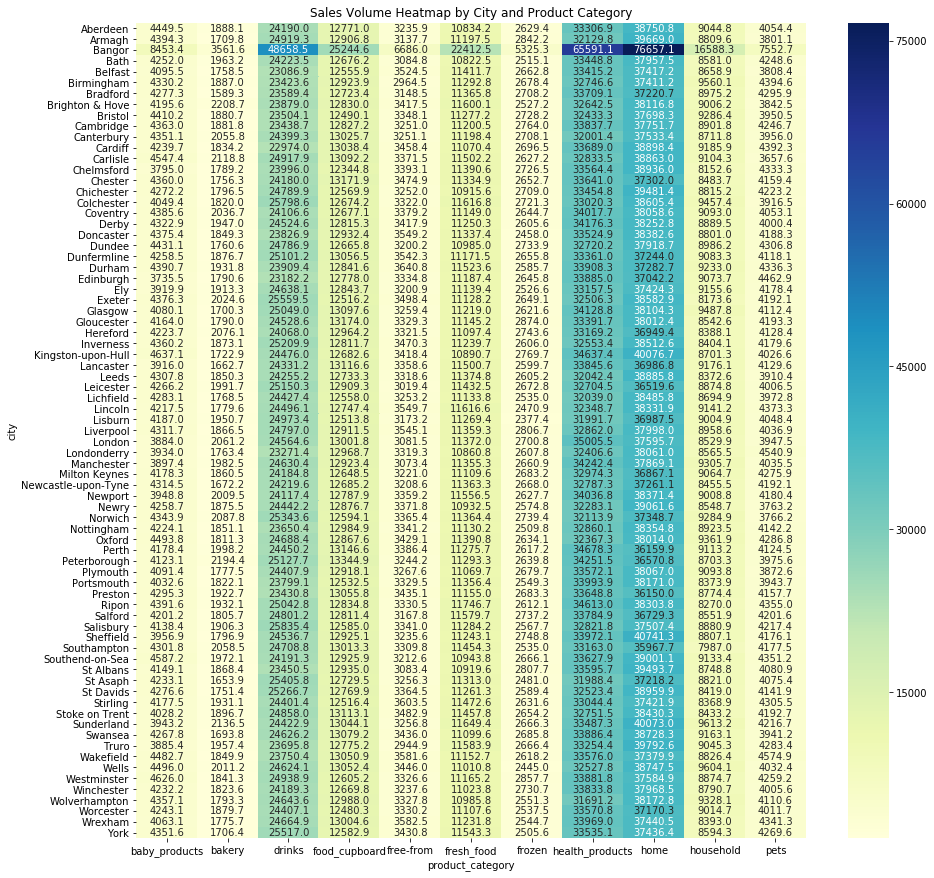

In [49]:
##Sales Volume Heatmap by City and Product Category
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your Spark DataFrame

# Aggregate sales by city and product category
sales_volume = df.groupBy("city", "product_category").agg(F.sum("price").alias("total_sales"))

# Convert to Pandas DataFrame for plotting
sales_volume_pd = sales_volume.toPandas()

# Pivot the DataFrame for the heatmap
sales_volume_heatmap_data = sales_volume_pd.pivot("city", "product_category", "total_sales")

# Plotting the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(sales_volume_heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Sales Volume Heatmap by City and Product Category')
plt.show()



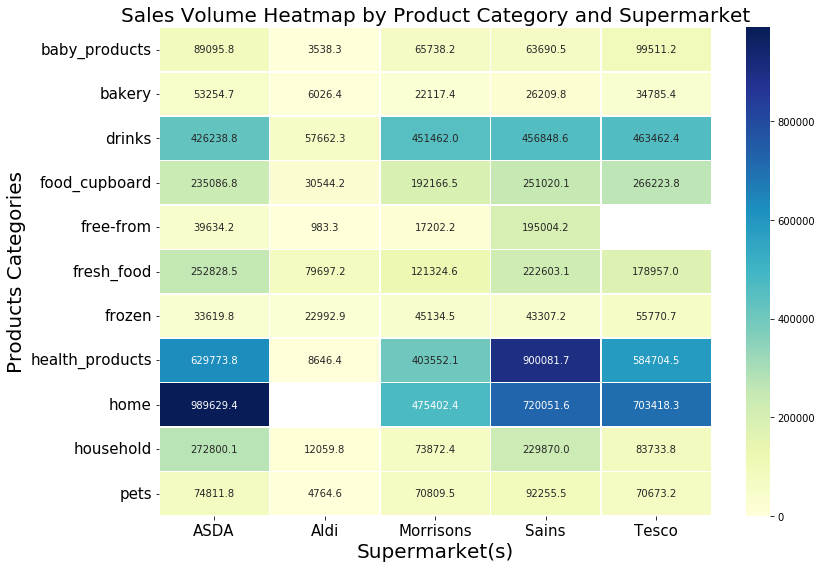

In [50]:
##Sales Volume Heatmap by Supermarkets and Product Category

# Aggregate sales by supermarket and product category
sales_volume = df.groupBy("supermarket", "product_category").agg(F.sum("price").alias("total_sales"))

# Convert to Pandas DataFrame for plotting
sales_volume_pd = sales_volume.toPandas()

# Pivot the DataFrame for the heatmap, swapping the axes
sales_volume_heatmap_data = sales_volume_pd.pivot("product_category", "supermarket", "total_sales")

# Plotting the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(sales_volume_heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title('Sales Volume Heatmap by Product Category and Supermarket',fontsize=20)
plt.xlabel("Supermarket(s)", fontsize=20)  # Adjust fontsize as needed
plt.ylabel("Products Categories", fontsize=20)
plt.xticks(rotation=0, ha="center",fontsize=15)
plt.yticks(rotation=0,va="center",fontsize=15)
plt.tight_layout()

plt.show()

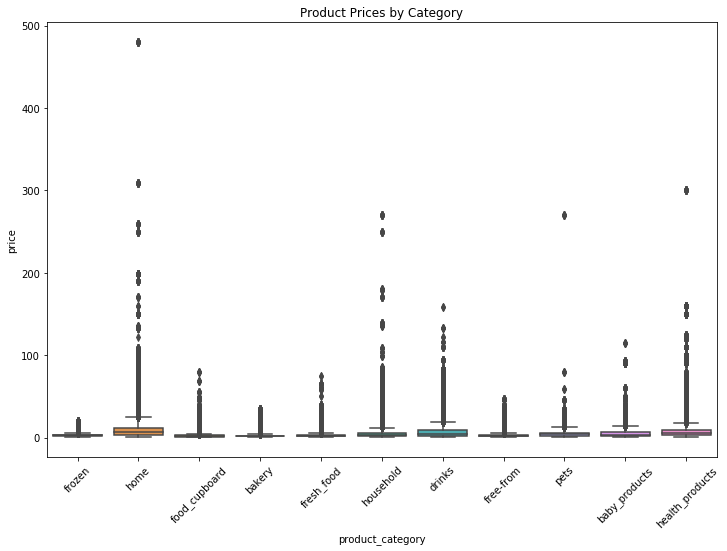

In [3]:
##Box Plot of Product Prices by Category
# Assuming 'df' is your PySpark DataFrame
df_pd = df.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

# Now that df_pd is defined, plot the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='product_category', y='price', data=df_pd)
plt.xticks(rotation=45)
plt.title('Product Prices by Category')
plt.show()


In [49]:
spark.stop()

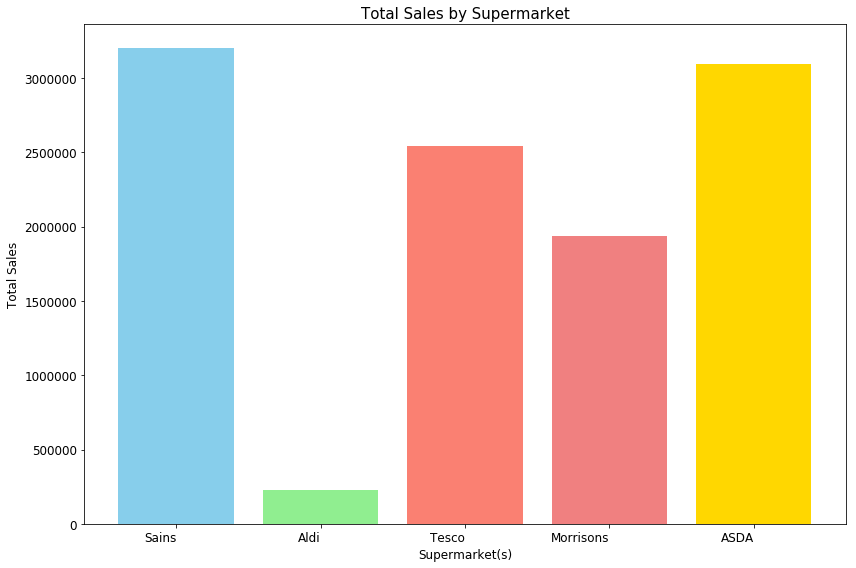

In [16]:
## FIG 1. Total Sales by Supermarket 


# Group by "supermarket" and calculate total sales
sales_by_supermarket = df.groupby("supermarket").agg(F.sum("price").alias("total_sales"))

# Convert PySpark DataFrame to Pandas DataFrame for plotting
sales_pd = sales_by_supermarket.toPandas()

# Define colors for the bars
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral', 'gold', 'lightblue']

# Plot the bar graph
plt.figure(figsize=(12,8))
plt.bar(sales_pd["supermarket"], sales_pd["total_sales"], color=colors, align='center')
plt.xlabel("Supermarket(s)", fontsize=12)  # Adjust fontsize as needed
plt.ylabel("Total Sales", fontsize=12)
plt.title("Total Sales by Supermarket",fontsize=15)
plt.xticks(rotation=0, ha='right',fontsize=12)
plt.yticks(rotation=0, ha='right',fontsize=12)
plt.tight_layout()


plt.show()

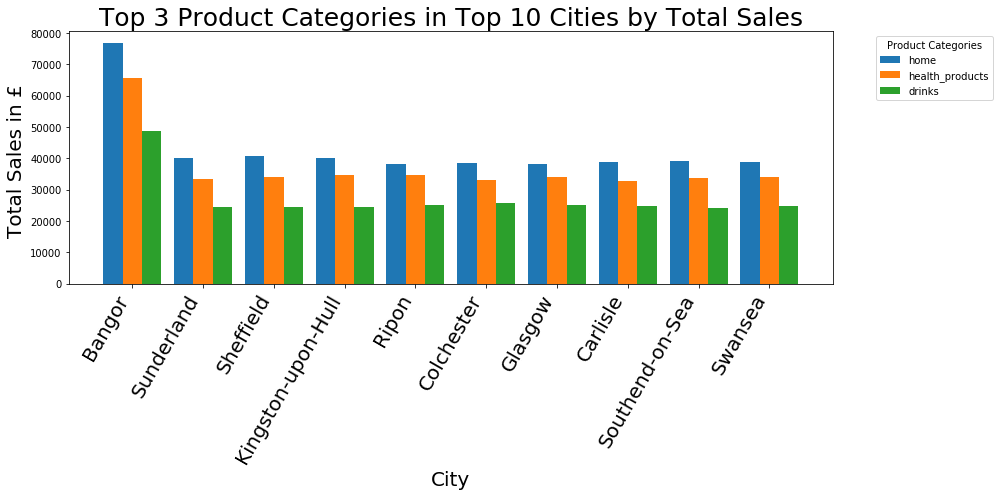

In [32]:
## FIg 6.1 Top 3 Product Categories in Top 10 Cities by Total Sales

# Step 1: Identify top 10 cities by total sales
city_sales = df.groupBy("city").agg(F.sum("price").alias("total_sales"))
top_cities = city_sales.orderBy(F.col("total_sales").desc()).limit(10)
top_cities_list = [row['city'] for row in top_cities.collect()]

# Step 2: Within each of these cities, find the top 3 product categories
windowSpec = Window.partitionBy("city").orderBy(F.col("total_sales").desc())
top_categories = (df.groupBy("city", "product_category")
                      .agg(F.sum("price").alias("total_sales"))
                      .withColumn("rank", F.rank().over(windowSpec))
                      .filter((F.col("rank") <= 3) & (F.col("city").isin(top_cities_list)))
                      .orderBy("city", "rank"))

# Convert to Pandas DataFrame for easier manipulation and plotting
top_categories_pd = top_categories.toPandas()

# Identify all unique categories across top cities to assign colors
unique_categories = top_categories_pd['product_category'].unique()

# Define a list of custom colors (as many as the number of unique categories).
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Ensure there are enough colors for the categories
if len(unique_categories) > len(custom_colors):
    print("Not enough custom colors defined for the number of categories.")
else:
    category_colors = dict(zip(unique_categories, custom_colors[:len(unique_categories)]))


# Prepare data for a nested bar chart
n_categories = 3
bar_width = 0.15
space = 0.1
group_width = n_categories * bar_width + space
index = np.arange(len(top_cities_list)) * group_width

# Plotting the nested bar chart
plt.figure(figsize=(14, 7))

# Use this to collect labels and handles for the legend
labels_and_handles = []

for i, city in enumerate(top_cities_list):
    city_data = top_categories_pd[top_categories_pd['city'] == city]
    for j in range(1, n_categories + 1):
        category_data = city_data[city_data['rank'] == j]
        for _, row in category_data.iterrows():
            color = category_colors[row['product_category']]
            handle = plt.bar(index[i] + (j-1) * bar_width, row['total_sales'], width=bar_width, color=color)
            if i == 0:  # Only add to legend once, for the first city
                labels_and_handles.append((row['product_category'], handle))

plt.title('Top 3 Product Categories in Top 10 Cities by Total Sales', fontsize=25)
plt.xlabel('City', fontsize=20)
plt.ylabel('Total Sales in £ ', fontsize=20)
plt.xticks(index + bar_width, top_cities_list, rotation=60, ha='right', fontsize=20)

# Creating the legend manually from collected labels and handles
plt.legend([handle[1] for handle in labels_and_handles], [label[0] for label in labels_and_handles], title='Product Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


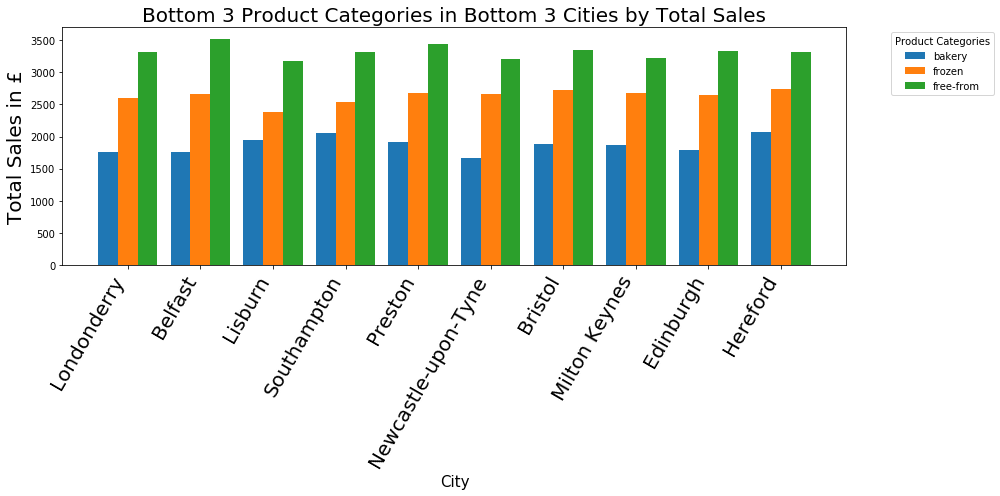

In [35]:
## FIg 6.2 Least 3 Product Categories in Least 10 Cities by Total Sales

# Step 1: Identify bottom 3 cities by total sales
city_sales = df.groupBy("city").agg(F.sum("price").alias("total_sales"))
bottom_cities = city_sales.orderBy(F.col("total_sales").asc()).limit(10)
bottom_cities_list = [row['city'] for row in bottom_cities.collect()]

# Step 2: Within each of these cities, find the bottom 3 product categories
windowSpec = Window.partitionBy("city").orderBy(F.col("total_sales").asc())
bottom_categories = (df.groupBy("city", "product_category")
                      .agg(F.sum("price").alias("total_sales"))
                      .withColumn("rank", F.rank().over(windowSpec))
                      .filter((F.col("rank") <= 3) & (F.col("city").isin(bottom_cities_list)))
                      .orderBy("city", "rank"))

# Convert to Pandas DataFrame for easier manipulation and plotting
bottom_categories_pd = bottom_categories.toPandas()

# Prepare data for a nested bar chart
n_categories = 3  # Number of product categories per city
bar_width = 0.15  # Width of individual category bars
space = 0.1  # Space between each group of bars for each city
group_width = n_categories * bar_width + space  # The total width of each city's group of bars
index = np.arange(len(bottom_cities_list)) * group_width

# Plotting the nested bar chart
plt.figure(figsize=(14, 7))

for i in range(1, n_categories + 1):
    # Offset each category bar within each city group
    category_pos = index + (i - 1) * bar_width
    category_data = bottom_categories_pd[bottom_categories_pd['rank'] == i].set_index('city').reindex(bottom_cities_list)
    plt.bar(category_pos, category_data['total_sales'], width=bar_width, label=f'Category {i}')

# Add city labels to the x-axis
city_labels = []
for city in bottom_cities_list:
    city_labels.extend([city] * n_categories)

# This will position the city label in the middle of each city's group of bars
plt.title('Bottom 3 Product Categories in Bottom 3 Cities by Total Sales', fontsize=20)
plt.xlabel('City', fontsize=15)
plt.ylabel('Total Sales in £', fontsize=20)
plt.xticks(index + (n_categories - 1) * bar_width / 2, bottom_cities_list, rotation=60, ha='right',fontsize=20)

# Add the category names to the legend
category_labels = bottom_categories_pd['product_category'].unique()
plt.legend(category_labels, title='Product Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


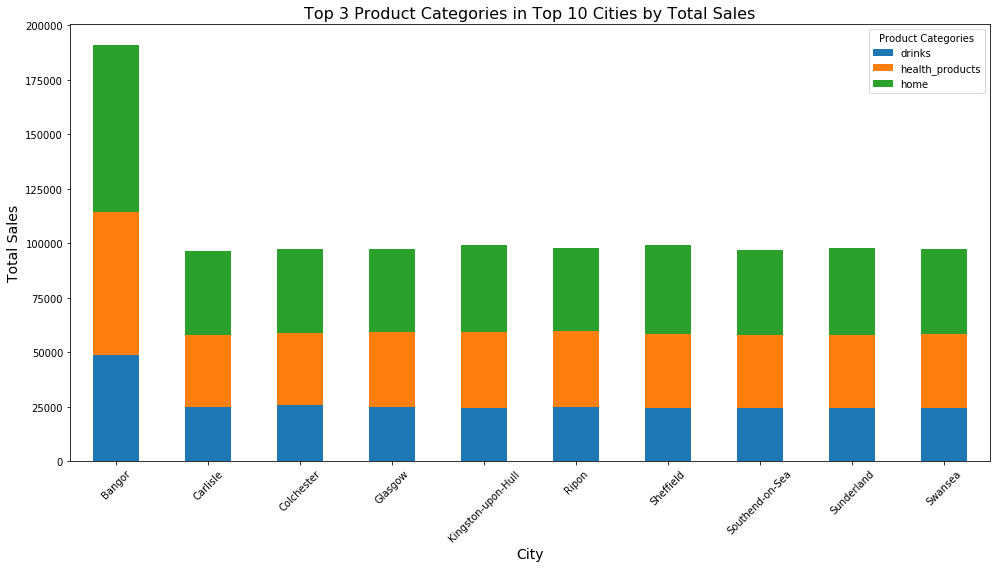

In [32]:
## DRAFT  Stack Bar Chart
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Identify top 10 cities by total sales
city_sales = df.groupBy("city").agg(F.sum("price").alias("total_sales"))
top_cities = city_sales.orderBy(F.col("total_sales").desc()).limit(10)
top_cities_list = [row['city'] for row in top_cities.collect()]

# Step 2: Within each of these cities, find the top 3 product categories
windowSpec  = Window.partitionBy("city").orderBy(F.col("total_sales").desc())
top_categories = (df.groupBy("city", "product_category")
                    .agg(F.sum("price").alias("total_sales"))
                    .withColumn("rank", F.rank().over(windowSpec))
                    .filter((F.col("rank") <= 3) & (F.col("city").isin(top_cities_list)))
                    .orderBy("city", "rank"))

# Convert this to Pandas DataFrame for easier manipulation and plotting
top_categories_pd = top_categories.toPandas()

# Create a pivot table for the stacked bar chart
pivot_df = top_categories_pd.pivot(index='city', columns='product_category', values='total_sales')

# Plotting the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(14, 8))

# Setting the titles and labels
plt.title('Top 3 Product Categories in Top 10 Cities by Total Sales', fontsize=16)
plt.xlabel('City', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Product Categories')

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()


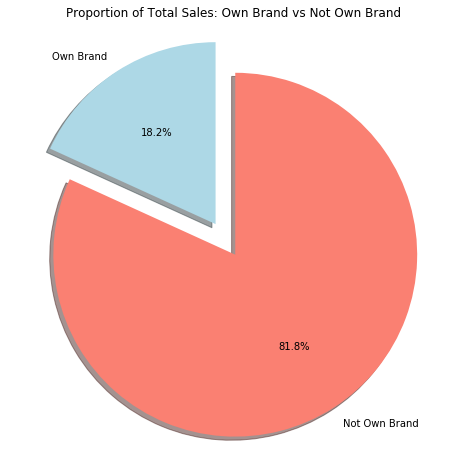

In [36]:
## Fig 7.1 alternative(explode effect): Proportion of Total Sales: Own Brand vs Not Own Brand

# from pyspark.sql import functions as F
# import matplotlib.pyplot as plt

# Assuming filtered_df is your DataFrame after filtering

# Aggregate sales by own_brand status
sales_by_own_brand = filtered_df.groupBy("own_brand").agg(F.sum("price").alias("total_sales"))

# Collect the aggregated data
sales_data = sales_by_own_brand.collect()

# Prepare data for the pie chart
labels = ['Own Brand' if row['own_brand'] else 'Not Own Brand' for row in sales_data]
sizes = [row['total_sales'] for row in sales_data]
colors = ['lightblue', 'salmon']  # Define two distinct colors
explode = (0.1, 0.1)  # Add a slight explode effect to both slices

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Proportion of Total Sales: Own Brand vs Not Own Brand')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|product_category|                 1|                 2|                 3|                 4|                 5|                 6|                 7|                 8|                 9|                10|                11|                12|
+----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|          frozen|16978.489999999947|15480.149999999936| 16684.64999999998|16649.680000000004|17248.820000000007| 16556.29999999999|17250.019999999975|17137.159999999978| 16140.68999999997|17152.619999999974|16489.539999999946| 17057.05999999997|
|      fresh

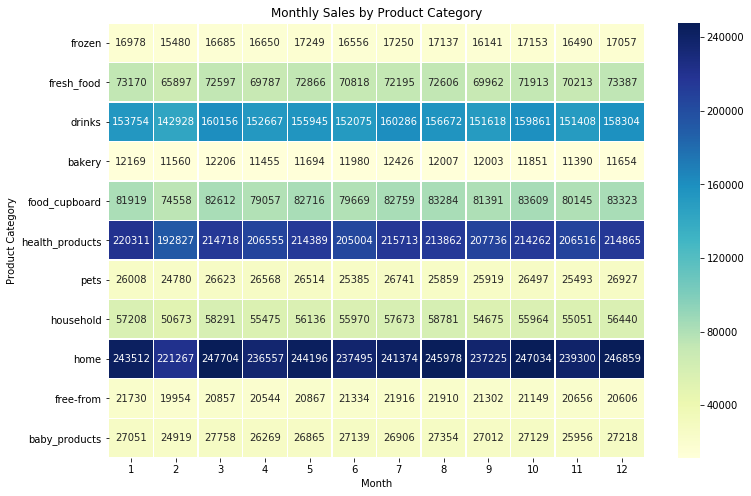

In [72]:
##
from pyspark.sql import SparkSession
from pyspark.sql.functions import month, sum as _sum

# Start the Spark session
spark = SparkSession.builder.appName("Sales Analysis").getOrCreate()

# Ensure that df is read correctly, for example:
# df = spark.read.csv("/path/to/your/data.csv", header=True, inferSchema=True)

# Add a month column derived from the date
df = df.withColumn("month", month("date"))

# Group by product category and month, then sum up the sales
monthly_sales = df.groupBy("product_category", "month").agg(_sum("price").alias("total_sales"))

# Pivot the data: categories as rows, months as columns
pivot_df = monthly_sales.groupBy("product_category").pivot("month").sum("total_sales").na.fill(0)

# Show the resulting DataFrame to check if it's correct
pivot_df.show()

# Convert to Pandas DataFrame for plotting (only if the data size is reasonable to fit in memory)
sales_data_for_heatmap = pivot_df.toPandas()

# Now you can plot the heatmap using the provided matplotlib and seaborn code


import seaborn as sns
import matplotlib.pyplot as plt

# Set the index to product category for better heatmap visualization
sales_data_for_heatmap.set_index("product_category", inplace=True)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(sales_data_for_heatmap, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title('Monthly Sales by Product Category')
plt.xlabel('Month')
plt.ylabel('Product Category')
plt.show()


Colormap  is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [130]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as sum_
from pyspark.sql.window import Window

# Initialize Spark session (if not already initialized)
spark = SparkSession.builder.appName("Top Products Analysis").getOrCreate()

# Assume 'df' is your loaded DataFrame
# Let's say you load it from a CSV or it's already been created somehow
# df = spark.read.csv('path_to_your_data.csv', header=True, inferSchema=True)

# Compute 'total_sales' correctly before any aggregation
df2 = df.withColumn("total_sales", col("price") * col("price_unit"))

# Step 1: Identify top categories by total sales
category_sales = df2.groupBy("product_category").agg(sum_("total_sales").alias("total_sales"))
top_categories = category_sales.orderBy(col("total_sales").desc()).limit(10)
top_categories_list = [row['product_category'] for row in top_categories.collect()]

# Step 2: Within each of these categories, find the top 3 products
windowSpec = Window.partitionBy("product_category").orderBy(col("total_sales").desc())
top_products = (df.filter(col("product_category").isin(top_categories_list))
                  .groupBy("product_category", "product_name")
                  .agg(sum_("total_sales").alias("total_sales"))
                  .withColumn("rank", F.rank().over(windowSpec))
                  .filter(col("rank") <= 3)
                  .orderBy("product_category", "rank"))

# Show result (or you can proceed to visualize or further process)
top_products.show()


AnalysisException: "cannot resolve '`total_sales`' given input columns: [price, supermarket, price_unit, city, product_name, measure_unit, date, own_brand, product_category];;\n'Aggregate [product_category#12632, product_name#12630], [product_category#12632, product_name#12630, sum('total_sales) AS total_sales#12748]\n+- Filter product_category#12632 IN (health_products,home,drinks,food_cupboard,household,pets,fresh_food,baby_products,free-from,frozen)\n   +- Relation[supermarket#12626,price#12627,price_unit#12628,measure_unit#12629,product_name#12630,date#12631,product_category#12632,own_brand#12633,city#12634] csv\n"

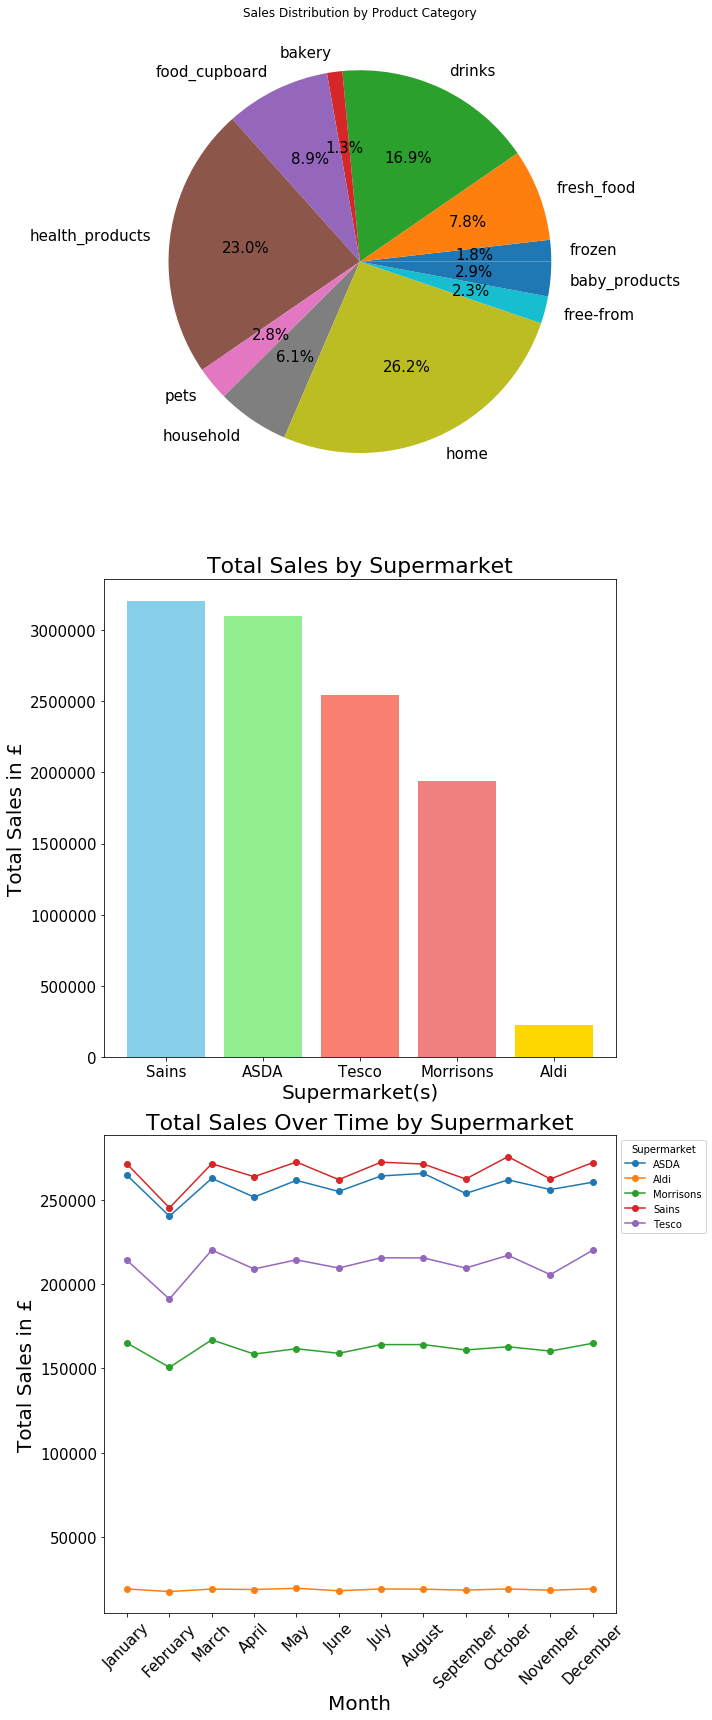

In [148]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import to_date, date_trunc

# Assuming 'df' is your PySpark DataFrame

# Setup the figure
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns

# Define a consistent color map for supermarkets
supermarkets = df.select("supermarket").distinct().rdd.flatMap(lambda x: x).collect()
colors = plt.get_cmap('tab10')  # This colormap has 10 colors, adjust if you have more supermarkets
color_dict = {supermarket: colors(i) for i, supermarket in enumerate(supermarkets)}

# Plot 1: Sales Distribution by Product Category (Pie Chart)
sales_by_category = df.groupBy("product_category").agg(F.sum("price").alias("total_sales"))
sales_by_category_pd = sales_by_category.toPandas()
axs[0].pie(sales_by_category_pd['total_sales'], labels=sales_by_category_pd['product_category'], autopct='%3.1f%%', textprops={'fontsize': 15})
axs[0].set_title('Sales Distribution by Product Category')

# Plot 2: Total Sales by Supermarket (sorted)
sales_by_supermarket = df.groupby("supermarket").agg(F.sum("price").alias("total_sales"))
sales_pd = sales_by_supermarket.toPandas().sort_values(by="total_sales", ascending=False)
sorted_supermarkets = sales_pd['supermarket']
sales_pd['color'] = sales_pd['supermarket'].apply(lambda x: color_dict[x])
axs[1].bar(sales_pd["supermarket"], sales_pd["total_sales"], color=sales_pd['color'], align='center')
axs[1].set_xlabel("Supermarket(s)", fontsize=20)
axs[1].set_ylabel("Total Sales in £", fontsize=20)
axs[1].set_title("Total Sales by Supermarket", fontsize=22)
axs[1].tick_params(axis='x', labelsize=15, rotation=0)
axs[1].tick_params(axis='y', labelsize=15)
handles = [plt.Rectangle((0, 0), 1, 1, color=color_dict[supermarket]) for supermarket in sorted_supermarkets]
axs[1].legend(handles, sorted_supermarkets, title="Supermarkets")

# Plot 3: Total Sales Over Time by Supermarket
df = df.withColumn("date", to_date(df.date, "yyyy-MM-dd"))
df = df.withColumn("month", date_trunc("month", df.date))
sales_by_supermarket_month = df.groupby("supermarket", "month").agg(F.sum("price").alias("total_sales")).orderBy("supermarket", "month")
sales_pd = sales_by_supermarket_month.toPandas()
sales_pd['month_name'] = sales_pd['month'].dt.strftime('%B')
sales_pd['color'] = sales_pd['supermarket'].apply(lambda x: color_dict[x])
supermarkets = sales_pd['supermarket'].unique()

for supermarket in supermarkets:
    df_filtered = sales_pd[sales_pd['supermarket'] == supermarket]
    axs[2].plot(df_filtered["month_name"], df_filtered["total_sales"], marker='o', linestyle='-', label=supermarket, color=color_dict[supermarket])

axs[2].set_xlabel("Month", fontsize=20)
axs[2].set_ylabel("Total Sales in £", fontsize=20)
axs[2].set_title("Total Sales Over Time by Supermarket", fontsize=22)
axs[2].tick_params(axis='x', labelsize=15, rotation=45)
axs[2].tick_params(axis='y', labelsize=15)
axs[2].legend(title="Supermarket", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()
